# Loading and combining AMPS Netcdfs 
### Another notebook for testing out methods of getting AMPS data into zarr format in our google bucket: gs://ldeo-glaciology 
We already have many AMPS netcdfs in the googlebucket https://storage.googleapis.com/ldeo-glaciology/AMPS/. 
Our aim to to combine them into an analysis-ready format.
AMPS_to_zarr.ipunb does this from local NCs.
This notebook does this from the NCs in the GB. 
(todo: work out how to authenticate write access to google bucket and write to zarr).

DFP: 2020-07-20

In [1]:
import xarray as xr
import fsspec
import zarr
import gcsfs
import os

from dask.diagnostics import ProgressBar
#from itertools import product
#from cftime import DatetimeNoLeap
from tqdm.autonotebook import tqdm
xr.set_options(display_style="html");


/Users/dporter/opt/anaconda3/envs/pangeo-amps/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


In [2]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab',
                         token='secrets/ldeo-glaciology-bc97b12df06b.json',
                        cache_timeout = 0)

In [3]:
gcsmap = gcsfs.mapping.GCSMap('gs://ldeo-glaciology', gcs=fs, check=False, create=False)

In [4]:
fs.ls('ldeo-glaciology')

['ldeo-glaciology/AMPS',
 'ldeo-glaciology/PISM_outputs',
 'ldeo-glaciology/RACMO_output',
 'ldeo-glaciology/bedmachine',
 'ldeo-glaciology/elizabeth',
 'ldeo-glaciology/elmer_janie']

In [5]:
# fs.listdir('ldeo-glaciology/AMPS/WRF_24/domain_03/')

## Example how to read post-processed (through NCL), CF-compliant files

In [6]:
path = 'gs://ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016120100_f003-cf.nc'
# https://storage.googleapis.com/ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016120100_f003-cf.nc

with fsspec.open(path) as f:
    ds = xr.open_dataset(f,
                       chunks={'south_north': 400, 'west_east': 400})

In [7]:
ds.keys()

KeysView(<xarray.Dataset>
Dimensions:   (pressure: 5, south_north: 825, time: 1, west_east: 537)
Coordinates:
  * time      (time) datetime64[ns] 2016-12-01T03:00:00
  * pressure  (pressure) float32 1000.0 850.0 700.0 500.0 300.0
    lat       (south_north, west_east) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    lon       (south_north, west_east) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Data variables:
    DateTime  (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    year      (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    month     (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    day       (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    hour      (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    minute    (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    Z_sfc     (south_north, west_east) float32 dask.array<chunksize=(400, 400),

### Take a look at one of the fields:
x-component of wind speed

In [8]:
ds['T_sfc']

<xarray.DataArray 'T_sfc' (time: 1, south_north: 825, west_east: 537)>
dask.array<open_dataset-8e6d1dccc699478a56fd3039e0251f6fT_sfc, shape=(1, 825, 537), dtype=float32, chunksize=(1, 400, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2016-12-01T03:00:00
    lat      (south_north, west_east) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    lon      (south_north, west_east) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Attributes:
    long_name:      Temperature at the Surface
    standard_name:  surface_temperature
    units:          K

In [9]:
ds['T_sfc'].plot()

### Plot a time series:
(choosing the time axis, and picking an arbitrary location in XYZ)

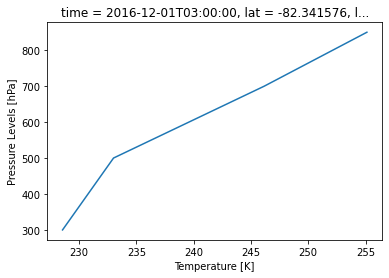

In [10]:
ds['T_p'].isel(south_north = 400, west_east = 300).plot(y='pressure')

## Example how to read RAW wrfout files

## Read multiple files

In [11]:
fs = gcsfs.GCSFileSystem(project='ldeo-glaciology', mode='ab', cache_timeout = 0)
NCs = fs.glob('gs://ldeo-glaciology/AMPS/WRF_24/domain_03/wrf-2016120*')

In [12]:
## load the first file to inialize the xarray
url = 'gs://' + NCs[0]
with  fsspec.open(url, mode='rb')  as openfile:  
    AMPS = xr.open_dataset(openfile, chunks={})  # these chunk sizes produce chunks of reasonable data volumes and which stretch through all time

## load the other files, each time concaternating them onto an xarray (AMPS) that grows in the time dimension each iteration. 
for i in tqdm(range(1, len(NCs)-1)):  
    url = 'gs://' + NCs[i]
    with  fsspec.open(url, mode='rb')  as openfile:  
        temp = xr.open_dataset(openfile, chunks={})  # these chunk sizes produce chunks of reasonable data volumes and which stretch through all time
    AMPS = xr.concat([AMPS,temp],'time')

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
# AMPS.U.isel(bottom_top = 0, south_north = 400, west_east_stag = 300).plot(x='XTIME')



## Use dask to set up a larger calculation: 
 the temporal mean over the domain

In [47]:
meanT = AMPS.T.mean(dim='Time')
meanT

<xarray.DataArray 'T' (bottom_top: 60, south_north: 825, west_east: 537)>
dask.array<mean_agg-aggregate, shape=(60, 825, 537), dtype=float32, chunksize=(60, 400, 400), chunktype=numpy.ndarray>
Dimensions without coordinates: bottom_top, south_north, west_east

### complete the computation

In [48]:
meanT.compute()

<xarray.DataArray 'T' (bottom_top: 60, south_north: 825, west_east: 537)>
array([[[-18.241245, -18.214176, -18.192036, ..., -34.290726,
         -34.239338, -34.189   ],
        [-18.229792, -18.200489, -18.170101, ..., -34.19582 ,
         -34.15154 , -34.11191 ],
        [-18.22233 , -18.186066, -18.148129, ..., -34.115765,
         -34.079723, -34.057854],
        ...,
        [-30.62238 , -30.596064, -30.569715, ..., -27.024414,
         -27.021593, -27.017683],
        [-30.56935 , -30.54437 , -30.523468, ..., -27.022036,
         -27.016064, -27.013096],
        [-30.514816, -30.495325, -30.476133, ..., -27.018833,
         -27.013906, -27.008158]],

       [[-17.657948, -17.63698 , -17.616932, ..., -33.806313,
         -33.737476, -33.672356],
        [-17.65187 , -17.6295  , -17.60837 , ..., -33.68664 ,
         -33.62458 , -33.56935 ],
        [-17.646826, -17.621431, -17.596516, ..., -33.585896,
         -33.535694, -33.49654 ],
        ...,
        [-29.926588, -29.903395, -29.87854 , ..., -26.806438,
         -26.803823, -26.800121],
        [-29.880758, -29.856321, -29.829145, ..., -26.794088,
         -26.7921  , -26.787952],
        [-29.836138, -29.809965, -29.780622, ..., -26.781765,
         -26.779547, -26.775766]],

       [[-17.171535, -17.151785, -17.13321 , ..., -33.351887,
         -33.266273, -33.18134 ],
        [-17.169758, -17.147322, -17.12767 , ..., -33.21758 ,
         -33.13567 , -33.05835 ],
        [-17.168276, -17.143225, -17.122084, ..., -33.09605 ,
         -33.026157, -32.962902],
        ...,
        [-29.226694, -29.204752, -29.184376, ..., -26.402454,
         -26.39681 , -26.390936],
        [-29.181904, -29.159502, -29.136478, ..., -26.398684,
         -26.392612, -26.385645],
        [-29.136469, -29.111864, -29.087988, ..., -26.393322,
         -26.386898, -26.37935 ]],

       ...,

       [[554.2773  , 554.2911  , 554.3057  , ..., 517.73096 ,
         517.82135 , 517.8674  ],
        [554.3036  , 554.3184  , 554.3324  , ..., 517.9068  ,
         517.9922  , 518.0137  ],
        [554.32996 , 554.3453  , 554.35803 , ..., 518.07544 ,
         518.13654 , 518.1161  ],
        ...,
        [508.35376 , 508.3349  , 508.3339  , ..., 505.97763 ,
         505.95697 , 505.9372  ],
        [508.34283 , 508.32877 , 508.33322 , ..., 505.9585  ,
         505.9356  , 505.9146  ],
        [508.3288  , 508.332   , 508.33636 , ..., 505.9423  ,
         505.91748 , 505.89288 ]],

       [[583.05536 , 583.0669  , 583.0793  , ..., 558.6536  ,
         558.716   , 558.7533  ],
        [583.0739  , 583.0877  , 583.0999  , ..., 558.7826  ,
         558.8438  , 558.86536 ],
        [583.0929  , 583.1071  , 583.11835 , ..., 558.91516 ,
         558.95917 , 558.9477  ],
        ...,
        [549.2396  , 549.2432  , 549.2481  , ..., 547.3247  ,
         547.30176 , 547.2782  ],
        [549.22296 , 549.22815 , 549.2358  , ..., 547.30164 ,
         547.2783  , 547.2543  ],
        [549.2023  , 549.21185 , 549.22034 , ..., 547.2783  ,
         547.2544  , 547.2306  ]],

       [[612.17816 , 612.19073 , 612.20276 , ..., 603.0339  ,
         603.0498  , 603.07263 ],
        [612.19147 , 612.2066  , 612.21844 , ..., 603.0743  ,
         603.0939  , 603.1133  ],
        [612.20465 , 612.21954 , 612.2297  , ..., 603.1253  ,
         603.1401  , 603.13983 ],
        ...,
        [592.6283  , 592.6423  , 592.6562  , ..., 591.5456  ,
         591.5236  , 591.50085 ],
        [592.5983  , 592.61005 , 592.62274 , ..., 591.51746 ,
         591.49554 , 591.4726  ],
        [592.56854 , 592.5789  , 592.59033 , ..., 591.48865 ,
         591.46643 , 591.44415 ]]], dtype=float32)
Dimensions without coordinates: bottom_top, south_north, west_east

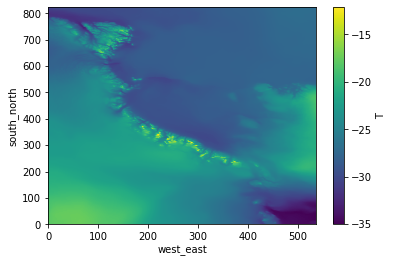

In [51]:
meanT.sel(bottom_top=0).plot()